Running simulation with 1 layers...
Number of layers 1
Step 0 out of 30
Step 5 out of 30
Step 10 out of 30
Step 15 out of 30
Step 20 out of 30
Step 25 out of 30
VQTE A List: [np.complex128(1+4.898587196589413e-16j), np.complex128(0.7470398169267174-3.6466688888124263e-16j), np.complex128(0.5830471074273422+1.7862931724190493e-16j), np.complex128(0.4899295489781322+1.836225020857252e-16j), np.complex128(0.44316852025806125+1.8132378877569403e-16j), np.complex128(0.42033015869654455+1.7903311153590494e-16j), np.complex128(0.40911033728228713+1.7762698640291138e-16j), np.complex128(0.403556496297875+1.768624992051664e-16j), np.complex128(0.40079424782136375+1.7646539631740686e-16j), np.complex128(0.39941686557797673+1.762631931712438e-16j), np.complex128(0.39872911871754557+1.7616118660880443e-16j), np.complex128(0.3983854824177444+1.761099580746497e-16j), np.complex128(0.39821372368170277+1.760842876187721e-16j), np.complex128(0.39812785918343585+1.760714383591952e-16j), np.complex128(0.

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


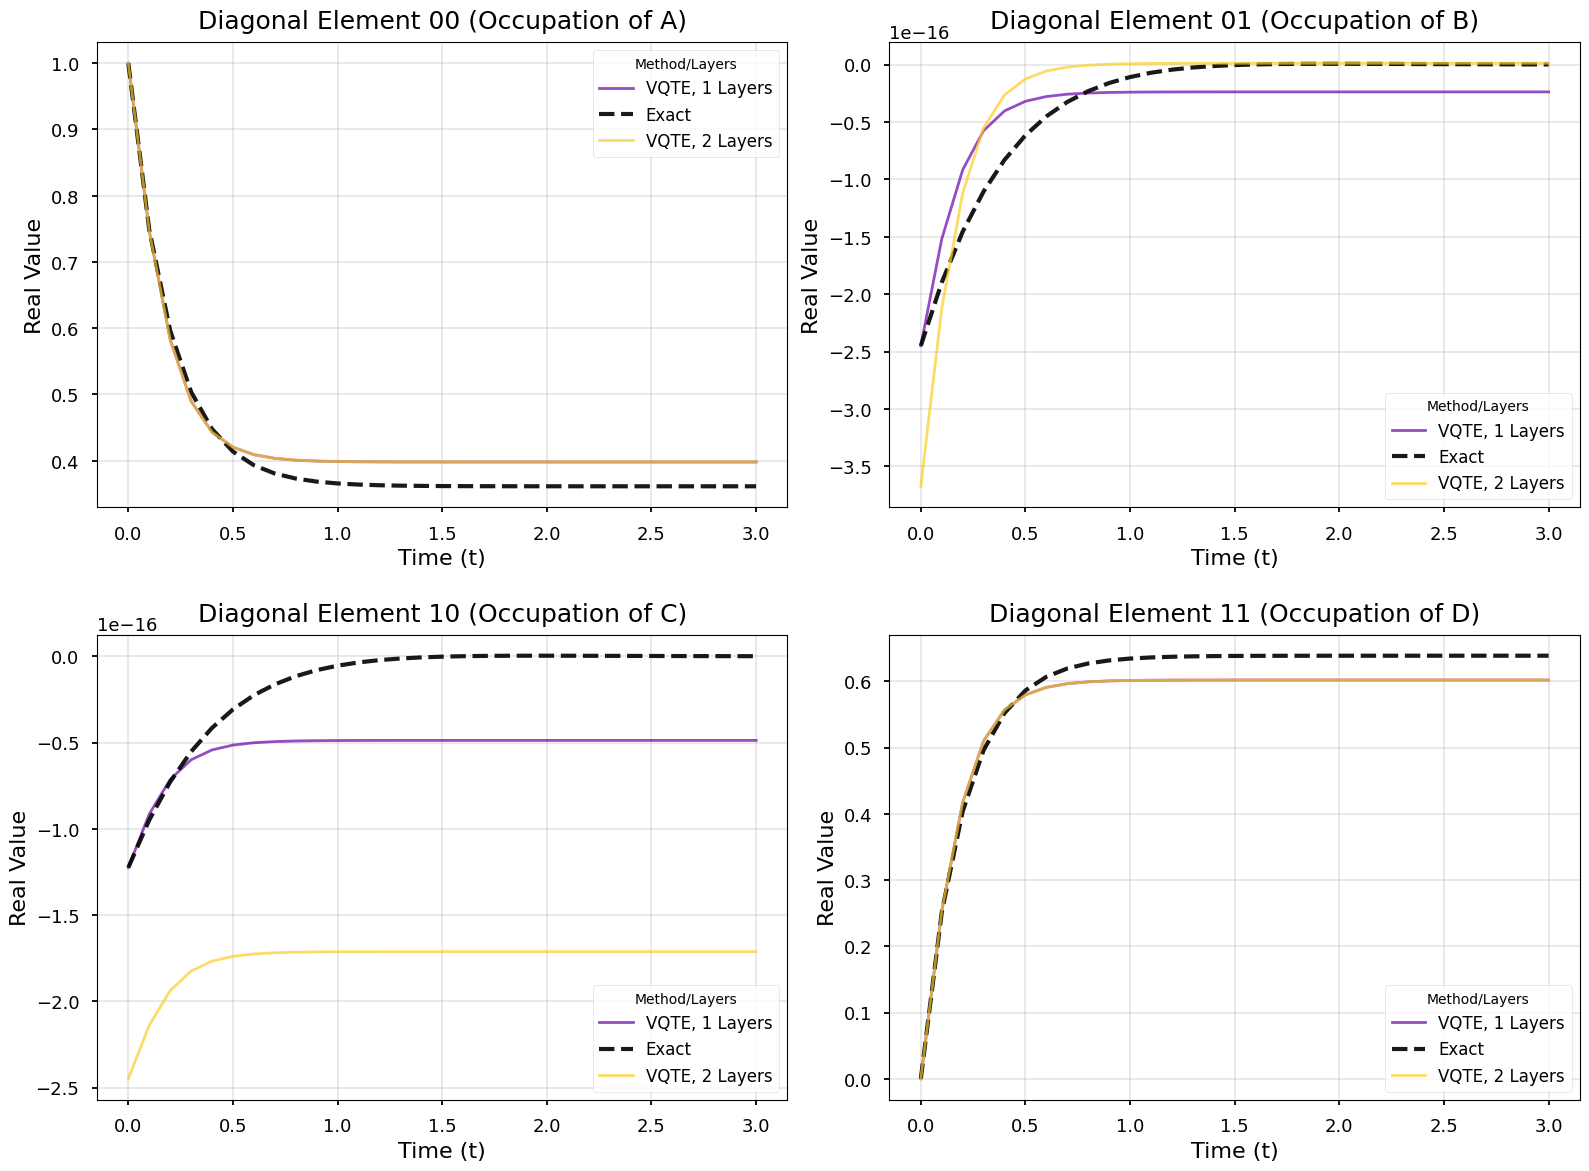

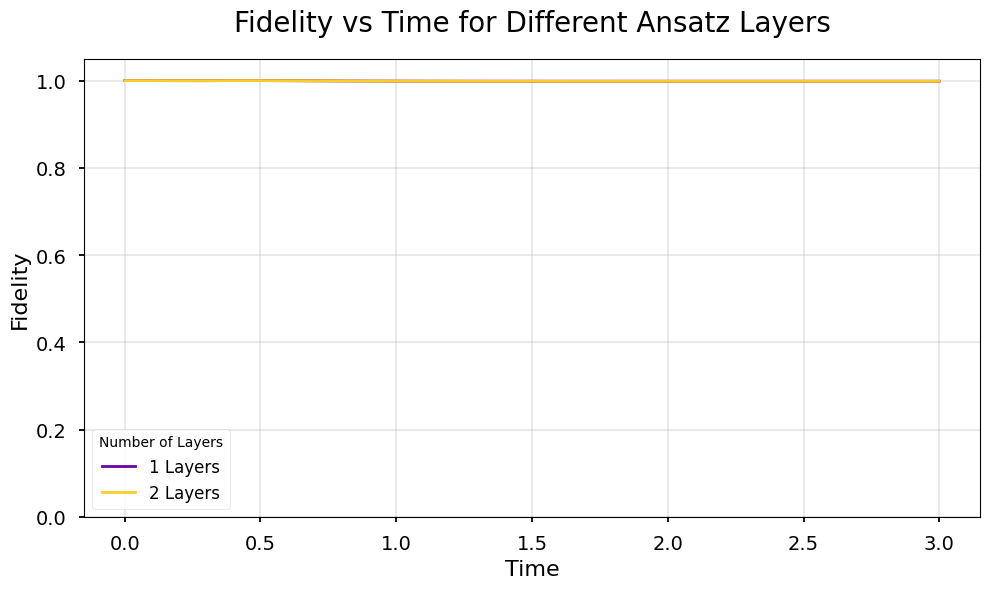

In [1]:
from fidelity_main import run_multiple_layers


def main():
    run_multiple_layers(2,3,0.1)
    
main()
